In [1]:
import pandas as pd
import numpy as np
data=pd.read_csv("Admission.csv")

1. 종속변수인 Chance_of_adimit와 독립변수 (GRE, TOEFL, Univ_Rating, SOP, LOR, CGPA)에 대해 피어슨 상관관계 분석을 수행하고 그래프를 이용하여 분석결과를 설명하시오.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GRE              400 non-null    int64  
 1   TOEFL            400 non-null    int64  
 2   Univ_Rating      400 non-null    int64  
 3   SOP              400 non-null    float64
 4   LOR              400 non-null    float64
 5   CGPA             400 non-null    float64
 6   Research         400 non-null    int64  
 7   Chance_of_Admit  400 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 25.1 KB


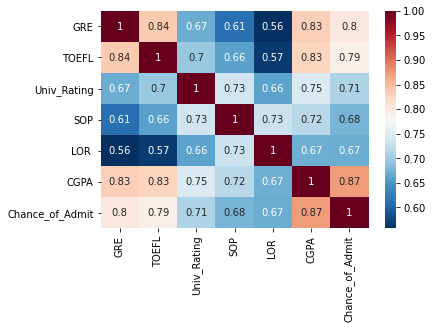

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

corr=data.drop(columns='Research').corr(method='pearson')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu_r', annot=True)
plt.show()

GRE, TOEFL, CGPA, Univ_Rating 변수가 종속변수 Chance_of_Admitr와 양의 상관관계를 갖는다고 판단함, 그 중 CGPA 변수의 상관계수가 0.87로 가장 많은 상관관계를 가짐

2. GRE, TOEFL, Univ_Rating, Sop, LOR, CGPA, Research가 Chance_of_Admit에 영향을 미치는지 알아보는 회귀분석을 단계적 선택법을 사용하여 수행하고 결과를 해석하시오.

In [4]:
import time 
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

def processSubset(X,y, feature_set):
    model = sm.OLS(y, X[list(feature_set)])
    regr = model.fit()
    AIC = regr.aic
    return {'model':regr, 'AIC':AIC}

#전진선택법
def forward(X,y,predictors):
    remaining_predictors = [p for p in X.columns.difference(['Intercept']) if p not in predictors]
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(X=X, y=y, feature_set=predictors + [p] + ['Intercept']))
        
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['AIC'].argmin()]
    print('Proceed', models.shape[0], 'models on', len(predictors)+1, 'predictors in')
    print('Selected predictors:', best_model['model'].model.exog_names, 'AIC:', best_model[0])
    return best_model

#후진소거법
def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors) -1):
        results.append(processSubset(X=X, y=y, feature_set=list(combo) + ['Intercept']))
    
    models = pd.DataFrame(results)
    best_model= models.loc[models['AIC'].argmin()]
    toc = time.time()
    
    print('Processed', models.shape[0], 'models on', len(predictors)-1, 'predictors in', (toc-tic))
    print('Selected predictors:', best_model['model'].model.exog_names,
          'AIC:', best_model[0])
    return best_model

#단계적 선택법
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=['AIC','model'])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y, predictors+['Intercept'])['AIC']
    
    for i in range(1, len(X.columns.difference(['Intercept']))+1):
        Forward_result = forward(X=X, y=y, predictors=predictors)
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]['model'].model.exog_names
        predictors = [k for k in predictors if k!= 'Intercept']
        Backward_result = backward(X=X, y=y, predictors=predictors)
        
        if Backward_result['AIC'] < Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            Smodel_before = Stepmodels.loc[i]['AIC']
            predictors = [k for k in predictors if k!='Intercept']
            print('backward')
            
        if Stepmodels.loc[i]['AIC'] > Smodel_before:
            break
        
        else:
            Smodel_before = Stepmodels.loc[i]['AIC']
            
    toc = time.time()
    print('Total elapsed time : ',(toc-tic), 'seconds') 
    
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [5]:
data.columns=data.columns.str.replace(" ", "")

In [6]:
from patsy import dmatrices
y,X = dmatrices('Chance_of_Admit ~ GRE + TOEFL + Univ_Rating + SOP + LOR + CGPA + Research', data = data, return_type='dataframe')
Stepwise_best_model = Stepwise_model(X=X,y=y)
Stepwise_best_model.summary()

Proceed 7 models on 1 predictors in
Selected predictors: ['CGPA', 'Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000011E3C55DD00>
forward
Processed 1 models on 0 predictors in 0.006346225738525391
Selected predictors: ['Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000011E33378940>
Proceed 6 models on 2 predictors in
Selected predictors: ['CGPA', 'GRE', 'Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000011E421F6520>
forward
Processed 2 models on 1 predictors in 0.011966705322265625
Selected predictors: ['CGPA', 'Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000011E42309A90>
Proceed 5 models on 3 predictors in
Selected predictors: ['CGPA', 'GRE', 'LOR', 'Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000011E423099D0>
forward
Processed 3 models on 2 predictors in

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance_of_Admit   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     320.6
Date:                Sat, 17 Sep 2022   Prob (F-statistic):          2.04e-136
Time:                        17:00:59   Log-Likelihood:                 536.61
No. Observations:                 400   AIC:                            -1061.
Df Residuals:                     394   BIC:                            -1037.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CGPA           0.1210      0.012     10.312      0.000       0.098       0.144
GRE            0.0018      0.001      2.992      0.003       0.001       0.003
LOR            0.0228      0.005      4.741      0.000       0.013       0.032
Research       0.0246      0.008      3.103      0.002       0.009       0.040
TOEFL          0.0030      0.001      2.847      0.005       0.001       0.005
Intercept     -1.2985      0.117    -11.070      0.000      -1.529      -1.068
==============================================================================
Omnibus:                       87.489   Durbin-Watson:                   0.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.337
Skew:                          -1.157   Prob(JB):                     1.14e-39
Kurtosis:                       5.325   Cond. No.                     1.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

3. 단계선택법을 사용해 변수를 선택한 후 새롭게 생성한 회귀모형에 대한 잔차분석을 수행하고 그래프를 활용하여 결과를 해석하시오.

회귀분석 결과를 바탕으로 다양한 잔차분석을 실시한다.

잔차의 독립성, 정규성, 등분산성을 만족하는지 봐야한다. 

(1) 모형의 선형성

- 예측값과 잔차의 비교
- 모든 예측값에서 잔차가 비슷하게 있어야함(가운데 점선)
- 빨간 실선은 잔차의 추세를 나타냄
- 빨간 실선이 점선에서 크게 벗어난다면 예측값에 따라 잔차가 크게 달라진다는 것

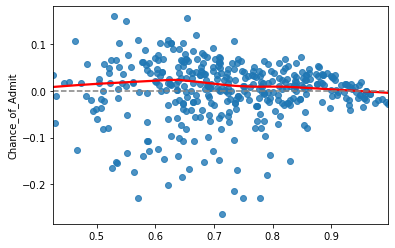

In [7]:
import warnings
warnings.filterwarnings('ignore')

fitted=Stepwise_best_model.predict()
residual=data['Chance_of_Admit']-fitted

sns.regplot(fitted, residual, lowess=True, line_kws={'color':'red'})
plt.plot([fitted.min(), fitted.max()], [0,0], '--', color='grey')

(2) 정규성
- 잔차가 정규분포를 따른다는 가정
- Q-Q플롯으로 확인 가능
- 잔차가 정규분포를 띄면 Q-Q플롯에서 점선을 따라 배치되어 있어야함

In [8]:
import scipy.stats
sr=scipy.stats.zscore(residual)
(x, y), _=scipy.stats.probplot(sr)

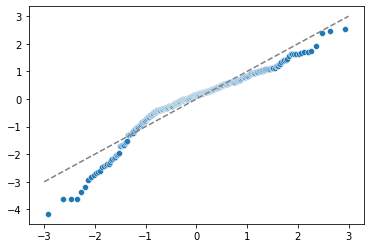

In [9]:
sns.scatterplot(x,y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

잔차의 정규성은 샤피로 검정으로 확인할 수 있다.

In [10]:
scipy.stats.shapiro(residual)

ShapiroResult(statistic=0.9219251275062561, pvalue=1.4429574885215651e-13)

p값이 0.05보다 작으므로 귀무가설은 기각된다. 즉 정규성이 위반되었다고 할 수 있다.

(3) 잔차의 등분산성
- 회귀모형을 통해 예측된 값이 크던 작던, 모든 값들에 대해 잔차의 분산이 동일하다는 가정
- 아래 그래프는 예측값(가로축)에 따라 잔차가 어떻게 달라지는 지 보여줌
- 빨간색 실선이 수평선을 그리는 것이 이상적

<AxesSubplot:ylabel='Chance_of_Admit'>

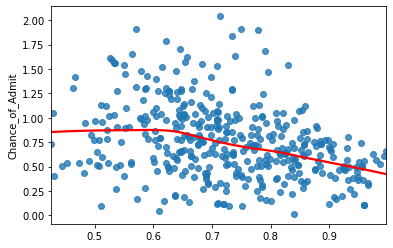

In [11]:
import numpy as np
sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color':'red'})

(4) 잔차의 독립성
- 회귀분석에서 잔차는 정규성, 등분상성 그리고 독립성을 가지는 것으로 가정
- 자료 수집 과정에서 무작위 표집(random sampling)을 하였다면, 잔차의 독립성은 만족하는 것으로 봄
- 시계열 자료나 종단연구 자료처럼, 연구 설계 자체가 독립성을 담보할 수 없는 경우에는 더빈-왓슨 검정(Durbin-Watson test) 등을 실시